## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Looking at the dataset

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head(10)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1
5,2010-04-22 08:39:47 UTC,8.1,0,-73.980481,40.748995,-73.983508,40.766459,1
6,2010-04-23 19:27:00 UTC,4.9,0,-73.959535,40.779582,-73.947185,40.780223,1
7,2010-04-15 09:03:37 UTC,4.9,0,-74.002601,40.739419,-73.997912,40.730292,1
8,2010-04-20 08:58:00 UTC,2.9,0,-74.014005,40.704058,-74.013202,40.702877,1
9,2010-04-16 18:50:16 UTC,6.1,0,-73.977689,40.784175,-73.988639,40.778669,1


### Inspecting the target variable

In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

# Exploratory Data Analysis

### Since we have a mean of $10, trips are short, so for calculating distance from pickup to dropoff we will use Haversine Formula.

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Adding a datetime column and extracting insights


By converting our timestamps into datetime objects, we can pull out details such as the day of the week or whether it’s AM or PM. Since the original data is recorded in UTC and our entries are from April 2010, when New York was observing Daylight Saving Time, we’ll adjust the timestamps to Eastern Daylight Time by subtracting four hours from our datatime objects.

In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


### Now, We will see all the columns we have to work with 

In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

### Now, we will separate categorical columns from continuous columns

In [8]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

### Converting category columns to type category

In [9]:
# Converting our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [10]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [11]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [12]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [13]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

### Now, We will combine the three categorical columns into one input array and then convert that numpy array into tensor

In [14]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [15]:
# Converting categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

### Now, We will convert continuous columns into tensors in the same way

In [16]:
# Converting continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [17]:
conts.type()

'torch.FloatTensor'

### Converting Y label into tensor as well

In [18]:
# Converting labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [19]:
cats.shape, conts.shape, y.shape

(torch.Size([120000, 3]), torch.Size([120000, 6]), torch.Size([120000, 1]))

### Setting sizes for embedding layer

In [20]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [21]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [22]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [23]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [24]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [25]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.6418, -0.1684,  0.7740, -0.2722,  0.0183, -0.5029,  1.8819, -1.0535,
          -1.1608,  0.3237, -0.1362,  1.5744],
         [ 1.4700, -1.2676,  1.1757, -1.4258,  0.7583,  1.4522, -2.4679,  0.7894,
           1.7157,  1.0950, -0.9770, -1.1108],
         [-0.0685, -1.3068, -0.0188,  0.0579, -0.9785, -0.3106, -0.4826, -0.1547,
           0.8959, -0.5526,  0.5970,  1.5854],
         [ 0.5757, -0.6657, -2.0779,  0.1107,  1.3647, -1.4496,  1.4654,  1.4313,
          -1.7380, -0.4936,  0.4266,  1.4007]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.5651],
         [ 0.5651],
         [ 0.5651],
         [-1.4036]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3493, -0.5447,  1.0578, -0.5589],
         [ 0.0837,  0.1218, -2.0670, -1.4838],
         [ 0.0837,  0.1218, -2.0670, -1.4838],
         [-1.3470, -0.7111, -0.2086,  1.0211]], grad_fn=<EmbeddingBackward0>)]

In [26]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-0.6418, -0.1684,  0.7740, -0.2722,  0.0183, -0.5029,  1.8819, -1.0535,
         -1.1608,  0.3237, -0.1362,  1.5744,  0.5651, -0.3493, -0.5447,  1.0578,
         -0.5589],
        [ 1.4700, -1.2676,  1.1757, -1.4258,  0.7583,  1.4522, -2.4679,  0.7894,
          1.7157,  1.0950, -0.9770, -1.1108,  0.5651,  0.0837,  0.1218, -2.0670,
         -1.4838],
        [-0.0685, -1.3068, -0.0188,  0.0579, -0.9785, -0.3106, -0.4826, -0.1547,
          0.8959, -0.5526,  0.5970,  1.5854,  0.5651,  0.0837,  0.1218, -2.0670,
         -1.4838],
        [ 0.5757, -0.6657, -2.0779,  0.1107,  1.3647, -1.4496,  1.4654,  1.4313,
         -1.7380, -0.4936,  0.4266,  1.4007, -1.4036, -1.3470, -0.7111, -0.2086,
          1.0211]], grad_fn=<CatBackward0>)

In [27]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [28]:
z = selfembdrop(z)
z

tensor([[-0.0000, -0.0000,  0.0000, -0.4536,  0.0305, -0.0000,  0.0000, -1.7559,
         -1.9347,  0.0000, -0.2270,  0.0000,  0.9418, -0.5821, -0.9078,  1.7631,
         -0.9315],
        [ 0.0000, -0.0000,  1.9595, -2.3763,  1.2638,  2.4204, -0.0000,  0.0000,
          2.8594,  1.8251, -1.6284, -1.8513,  0.9418,  0.1394,  0.0000, -3.4450,
         -2.4730],
        [-0.1142, -2.1780, -0.0313,  0.0000, -0.0000, -0.0000, -0.8044, -0.0000,
          0.0000, -0.9210,  0.9949,  0.0000,  0.9418,  0.1394,  0.2029, -3.4450,
         -2.4730],
        [ 0.9595, -1.1095, -0.0000,  0.0000,  2.2745, -2.4160,  2.4423,  2.3855,
         -0.0000, -0.8227,  0.7110,  2.3344, -2.3393, -2.2450, -1.1852, -0.0000,
          1.7018]], grad_fn=<MulBackward0>)

### This is how we are passing categorized embeddings into the layers.

In [29]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [30]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [31]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Defining loss funtion and optimizer

In [32]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [34]:
len(cat_train)

48000

In [35]:
len(cat_test)

12000

### Training the model

In [36]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.56661701
epoch:  26  loss: 10.91412258
epoch:  51  loss: 10.22181129
epoch:  76  loss: 9.74222755
epoch: 101  loss: 9.18556976
epoch: 126  loss: 8.43115997
epoch: 151  loss: 7.42813635
epoch: 176  loss: 6.23109245
epoch: 201  loss: 5.07420969
epoch: 226  loss: 4.21224880
epoch: 251  loss: 3.89492035
epoch: 276  loss: 3.78456736
epoch: 300  loss: 3.70840764

Duration: 153 seconds


### Plotting the loss function

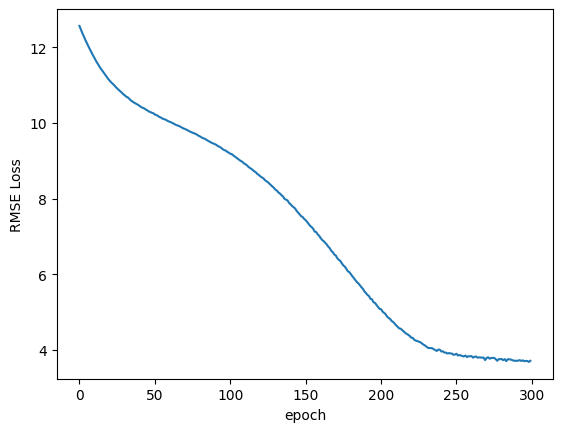

In [37]:
# Convert list of grad-requiring tensors to numpy floats
loss_vals = [l.detach().cpu().numpy() for l in losses]

plt.plot(range(epochs), loss_vals)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')
plt.show()

### Validating the model

In [38]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.67000055


#### We got RMSE of &plusmn;3.67000055, so let's see the first 50 predicted values

In [39]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.6291   2.9000   1.7291
 2.  26.1562   5.7000  20.4562
 3.   5.2842   7.7000   2.4158
 4.  14.2340  12.5000   1.7340
 5.   5.4137   4.1000   1.3137
 6.   4.7092   5.3000   0.5908
 7.   5.2722   3.7000   1.5722
 8.  13.3747  14.5000   1.1253
 9.   4.0286   5.7000   1.6714
10.  10.0626  10.1000   0.0374
11.   4.4109   4.5000   0.0891
12.   3.5622   6.1000   2.5378
13.   6.4453   6.9000   0.4547
14.  14.1368  14.1000   0.0368
15.   4.8472   4.5000   0.3472
16.  26.2673  34.1000   7.8327
17.   5.3032  12.5000   7.1968
18.   2.8916   4.1000   1.2084
19.  11.9606   8.5000   3.4606
20.   6.0070   5.3000   0.7070
21.  13.9001  11.3000   2.6001
22.   8.9708  10.5000   1.5292
23.  15.0856  15.3000   0.2144
24.  15.2047  14.9000   0.3047
25.  36.4652  49.5700  13.1048
26.   4.2417   5.3000   1.0583
27.   3.6954   3.7000   0.0046
28.   7.6729   6.5000   1.1729
29.  14.0105  14.1000   0.0895
30.   4.8512   4.9000   0.0488
31.   5.8694   3.7000   2.1694
32.  40.

#### Saving the model

In [40]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

#### Loading the saved model

In [41]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

#### Defining the model parameters

In [42]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

In [43]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Now we will write a function in which the user can pass new model parameters through our model to get the fare.

In [44]:
def test_data(mdl):
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [49]:
z = test_data(model2)


The predicted fare amount is $15.11


C:\Users\91957\AppData\Local\Temp\ipykernel_16324\485143692.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
